# Lab 6. RNN
### Importy

In [1]:
%matplotlib inline

import torch
from torch import nn
from torch.nn.functional import cross_entropy

from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Lambda, Compose

import numpy as np
import matplotlib.pyplot as plt 
from typing import Tuple, Optional

### Ładowanie danych
Na tych zajęciach będziemy traktować cyfry z MNISTa jako dane sekwencyjne, gdzie w danym kroku czasowym $T$ obserwujemy $T$-ty wiersz pikseli z cyfry.

In [2]:
transforms = Compose([ToTensor(), Lambda(lambda x: x.reshape(28, 28))])

train_data = MNIST(root='.', train=True, transform=transforms, download=True)
test_data = MNIST(root='.', train=False, transform=transforms)

## Zadanie 1.

Zaimplementuj "zwykłą" sieć rekurencyjną. 
![rnn](utils/rnn.png)

* W klasie `RNN` należy zainicjalizować potrzebne wagi oraz zaimplementować główną logikę dla pojedynczej chwili czasowej $x_t$
* Wyjście z sieci możemy mieć dowolny rozmiar, potrzebna jest również warstwa przekształcająca stan ukryty na wyjście.
* W pętli uczenia należy dodać odpowiednie wywołanie sieci. HINT: pamiętać o iterowaniu po wymiarze "czasowym".


In [3]:
class RNN(nn.Module):
    
    def __init__(self, 
                 input_size: int,
                 hidden_size: int,
                 output_size: int):
        """
        :param input_size: int
            Dimensionality of the input vector
        :param hidden_size: int
            Dimensionality of the hidden space
        :param output_size: int
            Desired dimensionality of the output vector
        """
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.input_to_hidden = torch.nn.Linear(input_size, hidden_size)
        self.hidden_to_hidden = torch.nn.Linear(hidden_size, hidden_size)
        self.hidden_to_output = torch.nn.Linear(hidden_size, output_size)
    
    # for the sake of simplicity a single forward will process only a single timestamp 
    def forward(self, 
                input: torch.tensor, 
                hidden: torch.tensor) -> Tuple[torch.tensor, torch.tensor]:
        """
        :param input: torch.tensor 
            Input tensor for a single observation at timestep t
            shape [batch_size, input_size] 
        :param hidden: torch.tensor
            Representation of the memory of the RNN from previous timestep
            shape [batch_size, hidden_size]
        """
        hidden = torch.tanh(self.input_to_hidden(input) + self.hidden_to_hidden(hidden))
        output = self.hidden_to_output(hidden)
        
        return output, hidden
    
    def init_hidden(self, batch_size: int) -> torch.Tensor:
        """
        Returns initial value for the hidden state
        """
        return torch.zeros(batch_size, self.hidden_size, requires_grad=True)

### Pętla uczenia

In [4]:
torch.manual_seed(1337)

grads = []

batch_size = 50

# build data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

# initialize network and optimizer
rnn = RNN(28, 64, 10)
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)
# I've changed learning rate from 0.01 to 0.001. Due to it, final accuracy increased from 0.5084 to 0.7991

# we will train for only a single epoch 
epochs = 1

# main loop
for epoch in range(epochs):
    
    for i, (x, y) in enumerate(train_loader):  
        
        optimizer.zero_grad()
        # get initial hidden state
        hidden = rnn.init_hidden(x.shape[0])
        
        # get output for the sample, remember that we treat it as a sequence
        # so you need to iterate over the 2nd, time dimensiotn
        
        seq_len = x.shape[1]
            
        hiddens = [] 
        for j in range(seq_len):
            output, hidden = rnn(x[:,j,:], hidden)
            hidden.retain_grad()
            hiddens.append(hidden)
        
        loss = cross_entropy(output, y)
        loss.backward()
        optimizer.step()
        
        grads.append([np.linalg.norm(h.grad.numpy()) for h in hiddens])
        
        if i % 100 == 1:
            print(f"Epoch: {epoch} Iter: {i}/{len(train_loader)} Loss: {loss}")

# evaluate on the test set
with torch.no_grad():
    
    correct = 0
    for i, (x, y) in enumerate(test_loader):

        hidden = rnn.init_hidden(x.shape[0])
        seq_len = x.shape[1]
        
        for j in range(seq_len):
            output, hidden = rnn(x[:,j,:], hidden)

        pred = output.argmax(dim=1)
        correct += int(sum(pred == y))
    
    accuracy = correct / (batch_size * len(test_loader))

    print(f"Final Accuracy: {accuracy}")
    assert accuracy > 0.4, "Subject to random seed you should get over 0.4 accuracy, try changing the seed!"

Epoch: 0 Iter: 1/1200 Loss: 2.308899402618408
Epoch: 0 Iter: 101/1200 Loss: 1.7872264385223389
Epoch: 0 Iter: 201/1200 Loss: 1.3791284561157227
Epoch: 0 Iter: 301/1200 Loss: 0.9696245789527893
Epoch: 0 Iter: 401/1200 Loss: 0.8591989278793335
Epoch: 0 Iter: 501/1200 Loss: 0.8213538527488708
Epoch: 0 Iter: 601/1200 Loss: 0.7441550493240356
Epoch: 0 Iter: 701/1200 Loss: 0.48766955733299255
Epoch: 0 Iter: 801/1200 Loss: 0.7282025218009949
Epoch: 0 Iter: 901/1200 Loss: 0.8720817565917969
Epoch: 0 Iter: 1001/1200 Loss: 0.44287264347076416
Epoch: 0 Iter: 1101/1200 Loss: 0.7427657246589661
Final Accuracy: 0.7991


## Zadanie 2
Dopisz kod do powyższej pętli, który zbiera gradienty po kolejnych stanach ukrytych dla przykładu. Pokaż (za pomocą wykresu numpy) efekt zanikającego gradientu rysując średnie normy gradientu dla każdego stanu ukrytego po każdym kroku. HINT: dla MNISTa mamy 28 kroków. 

**Ważne:** Ponieważ normalnie w torchu czyścimy wszystkie gradienty po każdej iteracji aby je zachować w dla niektórych wag przydatna będzie metoda [`retain_grad`](https://pytorch.org/docs/stable/autograd.html#torch.Tensor.retain_grad).

<BarContainer object of 28 artists>

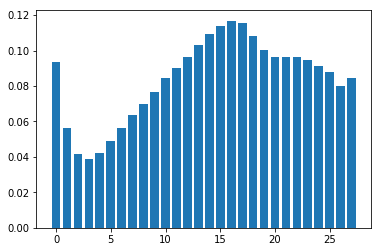

In [5]:
# mean_grads in assume to be a 1D array or list of average gradients norm per timestep memory 
mean_grads = np.mean(np.array(grads), axis=0)
plt.bar(x=np.arange(len(mean_grads)), height=mean_grads)

## Zadanie 3
Ostatnim zadaniem jest implementacji komórki i sieci LSTM. 

![lstm](utils/lstm.png)

* W klasie `LSTMCell` ma znaleźć się główna loginka LSTMa, czyli wszystkie wagi do stanów `hidden` i `cell` jak i bramek kontrolujących te stany. 
* W klasie `LSTM` powinno znaleźć się wywołanie komórki LSTM, HINT: poprzednio było w pętli uczenia, teraz przeniesiemy to do klasy modelu.
* W pętli uczenia należy uzupełnić brakujące wywołania do uczenia i ewaluacji modelu.

Zdecydowanie polecam [materiały Chrisa Olaha](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) do zarówno zrozumienia jak i ściągi do wzorów.

Zadaniem jest osiągnięcie dokładności na poziomie przynajmniej 90%, przy prawidłowej implementacji nie powinno być z tym problemów używając podanych hiperparametrów. Dozwolona jest oczywiście zmienia `random seed`.

### Komórka LSTM

In [6]:
class LSTMCell(nn.Module):

    def __init__(self, 
                 input_size: int, 
                 hidden_size: int):
        """
        :param input_size: int
            Dimensionality of the input vector
        :param hidden_size: int
            Dimensionality of the hidden space
        """
        
        super(LSTMCell, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size

        # initialize LSTM weights 
        # NOTE: there are different approaches that are all correct 
        # (e.g. single matrix for all input opperations), you can pick
        # whichever you like for this task
    
        self.W_f = torch.nn.Linear(input_size + hidden_size, hidden_size)
        self.W_i = torch.nn.Linear(input_size + hidden_size, hidden_size)
        self.W_c = torch.nn.Linear(input_size + hidden_size, hidden_size)
        self.W_o = torch.nn.Linear(input_size + hidden_size, hidden_size)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, 
                input: torch.tensor, 
                states: Tuple[torch.tensor, torch.tensor]) -> Tuple[torch.tensor, torch.tensor]:
        
        hidden, cell = states
        
        # Compute input, forget, and output gates
        # then compute new cell state and hidden state
        # see http://colah.github.io/posts/2015-08-Understanding-LSTMs/ 
        hidden_cat_input = torch.cat((hidden, input), dim=1)
        f_t = self.sigmoid(self.W_f(hidden_cat_input))
        i_t = self.sigmoid(self.W_i(hidden_cat_input))
        c_t = self.sigmoid(self.W_c(hidden_cat_input))
        cell = f_t * cell + i_t * c_t
        
        o_t = self.sigmoid(self.W_o(hidden_cat_input))
        hidden = o_t * torch.tanh(cell)
        
        return hidden, cell

### Klasa modelu LSTM

In [7]:
class LSTM(nn.Module):

    def __init__(self, 
                 input_size: int, 
                 hidden_size: int):
        """
        :param input_size: int
            Dimensionality of the input vector
        :param hidden_size: int
            Dimensionality of the hidden space
        """
        
        super(LSTM, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.cell = LSTMCell(input_size=input_size, hidden_size=hidden_size)
        
    def forward(self, 
                input: torch.tensor) -> Tuple[torch.tensor, torch.tensor]:
        """
        :param input: torch.tensor 
            Input tesnor for a single observation at timestep t
            shape [batch_size, input_size]
        Returns Tuple of two torch.tensors, both of shape [seq_len, batch_size, hidden_size]
        """
        
        batch_size = input.shape[0]
        
        hidden, cell = self.init_hidden_cell(batch_size)
        
        hiddens = []
        cells = []
        
        # this time we will process the whole sequence in the forward method
        # as oppose to the previous exercise, remember to loop over the timesteps
        
        seq_len = input.shape[1]
        
        for j in range(seq_len):
            hidden, cell = self.cell(input[:,j], (hidden, cell))
            cells.append(cell)
            hiddens.append(hidden)
               
        hiddens = torch.stack(hiddens, dim=0)
        cells = torch.stack(cells, dim=0)
        
        return hiddens, cells
    
    def init_hidden_cell(self, batch_size):
        """
        Returns initial value for the hidden and cell states
        """
        return (torch.zeros(batch_size, self.hidden_size, requires_grad=True), 
                torch.zeros(batch_size, self.hidden_size, requires_grad=True))

### Pętla uczenia

In [8]:
from itertools import chain

torch.manual_seed(2019)

batch_size = 50

# build data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

# initialize the lstm with an additional classifier layer at the top
lstm = LSTM(input_size=28, hidden_size=64)
clf = nn.Linear(in_features=64, out_features=10)

# initialize an optimizer
params = chain(lstm.parameters(), clf.parameters())
optimizer = torch.optim.Adam(params, lr=0.01) 

# we will train for only a single epoch 
epoch = 1

# main loop
for epoch in range(epoch):
    
    for i, (x, y) in enumerate(train_loader):        
        
        optimizer.zero_grad()
        
        # get output for the sample, remember that we treat it as a sequence
        # so you need to iterate over the sequence length here
        
        hiddens, _ = lstm(x)
        out = clf(hiddens[-1])
        loss = cross_entropy(out, y)
        loss.backward()
        optimizer.step()                                
        
        if i % 50 == 1:
            print(f"Epoch: {epoch} Iter: {i}/{len(train_loader)} Loss: {loss:.4f}")

# evaluate on the test set
with torch.no_grad():
    
    correct = 0
    for i, (x, y) in enumerate(test_loader):
        
        hiddens, _ = lstm(x) 
        out = clf(hiddens[-1])
        pred = out.argmax(dim=1)
        correct += int(sum(pred == y))
    
    accuracy = correct / (batch_size * len(test_loader))
    
    print(f"Final Accuracy: {accuracy}")
    assert accuracy > 0.9, "Subject to random seed you should get over 0.9 accuracy, try changing the seed!"

Epoch: 0 Iter: 1/1200 Loss: 2.3405
Epoch: 0 Iter: 51/1200 Loss: 1.8964
Epoch: 0 Iter: 101/1200 Loss: 1.6478
Epoch: 0 Iter: 151/1200 Loss: 1.2867
Epoch: 0 Iter: 201/1200 Loss: 1.1051
Epoch: 0 Iter: 251/1200 Loss: 1.0376
Epoch: 0 Iter: 301/1200 Loss: 0.9980
Epoch: 0 Iter: 351/1200 Loss: 0.9703
Epoch: 0 Iter: 401/1200 Loss: 0.9213
Epoch: 0 Iter: 451/1200 Loss: 0.7721
Epoch: 0 Iter: 501/1200 Loss: 0.1909
Epoch: 0 Iter: 551/1200 Loss: 0.4757
Epoch: 0 Iter: 601/1200 Loss: 0.3079
Epoch: 0 Iter: 651/1200 Loss: 0.5689
Epoch: 0 Iter: 701/1200 Loss: 0.3026
Epoch: 0 Iter: 751/1200 Loss: 0.2079
Epoch: 0 Iter: 801/1200 Loss: 0.2438
Epoch: 0 Iter: 851/1200 Loss: 0.0916
Epoch: 0 Iter: 901/1200 Loss: 0.2372
Epoch: 0 Iter: 951/1200 Loss: 0.0598
Epoch: 0 Iter: 1001/1200 Loss: 0.3145
Epoch: 0 Iter: 1051/1200 Loss: 0.2500
Epoch: 0 Iter: 1101/1200 Loss: 0.1729
Epoch: 0 Iter: 1151/1200 Loss: 0.1776
Final Accuracy: 0.9384
